# Semplici esempi su dati di chiusura S&P500 

workbook excel : "S&PMIB Esempio Simulazione.xls"

### Analisi dei Dati

In [2]:
options(warn=-1)
require(binhf)

# individuazione cartella di lavoro
require(stringr)
if(Sys.info()[1] == 'Windows'){
  if(Sys.info()[4] == 'CL100400200004')
    working_dir <- str_trim('D:/git/working/R/esempi')
  else
    working_dir <- str_trim('C:/git/working/R/credit risk modelling')
}else{
  working_dir <- str_trim('/Users/giovanni/git_repository/working/R/credit risk modelling')
}
cat("La cartella di lavoro e' : ", working_dir)

Loading required package: binhf
Loading required package: wavethresh
Loading required package: MASS
WaveThresh: R wavelet software, release 4.6.6, installed

Copyright Guy Nason and others 1993-2013

Note: nlevels has been renamed to nlevelsWT

Loading required package: adlift
Loading required package: EbayesThresh

 **********************************************
 adlift: a package to perform wavelet lifting schemes

 --- Written by Matt Nunes and Marina Knight ---
   Current package version:  1.3-2  ( 01/11/2012 ) 

             -+ packaged by MAN +-           
 **********************************************
 
 adlift 1.3-2 loaded


Attaching package: 'adlift'

The following object is masked from 'package:EbayesThresh':

    postmean.cauchy


 **********************************************
 binhf: Haar-Fisz functions for binomial data

 --- Written by Matt Nunes ---
   Current package version:  1.0-1  ( 24/04/2014 ) 

 
 **********************************************
 
 binhf 1.0-1 lo

La cartella di lavoro e' :  D:/git/working/R/esempi

In [3]:

# import del file contenente i dati relativi all'indice S&P MIB
file_name = paste(working_dir, 'ts_sp_mib.csv', sep="/")
ts <- read.csv(file_name)
ts$Date = as.Date(ts$Date)

attach(ts)

Per effettuare il calcolo dei rendimenti senza alcun loop, shiftiamo il vettore dei prezzi di una posizione e poi calcoliamo il logaritmo del rapporto, in questo modo otteniamo direttamente il vettore dei rendimenti $yield = \ln\Bigl({P_{t-1} \over P_{t}}\Bigr)$

In [4]:
# calcolo rendimenti
shift_price    <- shift(Price,1)
shift_price[1] <- 0
yield <- log(shift_price/Price)
yield[1] <- 0

Plottiamo la distribuzione di frequenza dei rendimenti sulla quale sovrapponiamo una gaussiana teorica con valor medio e standard deviation uguale a quella misurata dalla serie storica. Si noti che dovremmo normalizzare la distribuzione teorica, infatti l'integrale della distribuzione di frequenza riportata sopra è pari a $\Delta x \sum\limits_{i=1}^N f_i$ dove $\Delta x$ è l'ampiezza del bin e $f_i$ il valore della i-esima frequenza.

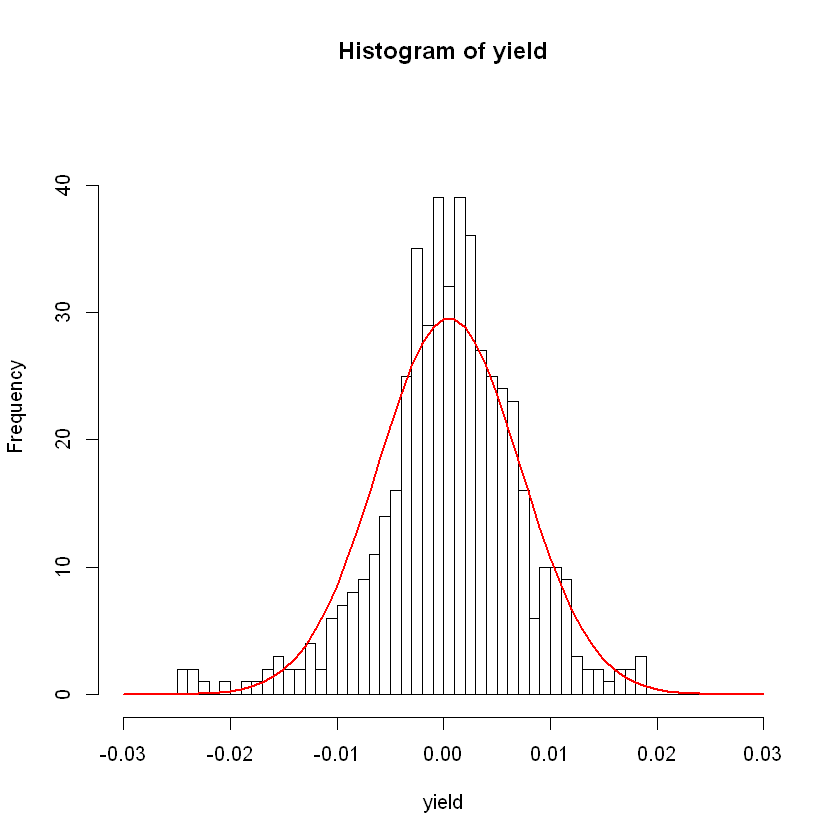

In [5]:
x <- seq(-.03,.03,.001)

# calcolo media e standard deviation
m <- mean(yield)
s <- sqrt(var(yield))

# calcolo il fattore di normalizzazione dell'area
delta <- x[2] - x[1]
ntot  <- length(yield)
A     <- delta * ntot

# normalizzazione x
xn <- (x-m)/s

f <- 1/(s*sqrt(2*pi))
y <- f * exp(-.5*xn*xn) * A

hist(yield,x ,ylim=c(0,45))
lines(x, y, col='red',lwd=2)


## Simulazione

In [6]:
# the following function simulates a trajectory of Brownian motion at time instants tt

wiener = function( n, tt ) {
  e = rnorm( n, 0, 1 )
  x = c(0,cumsum( e )) / sqrt(n)
  y = x[ 1+floor( n * tt ) ]
  return( list( x = x, y = y ) )
}

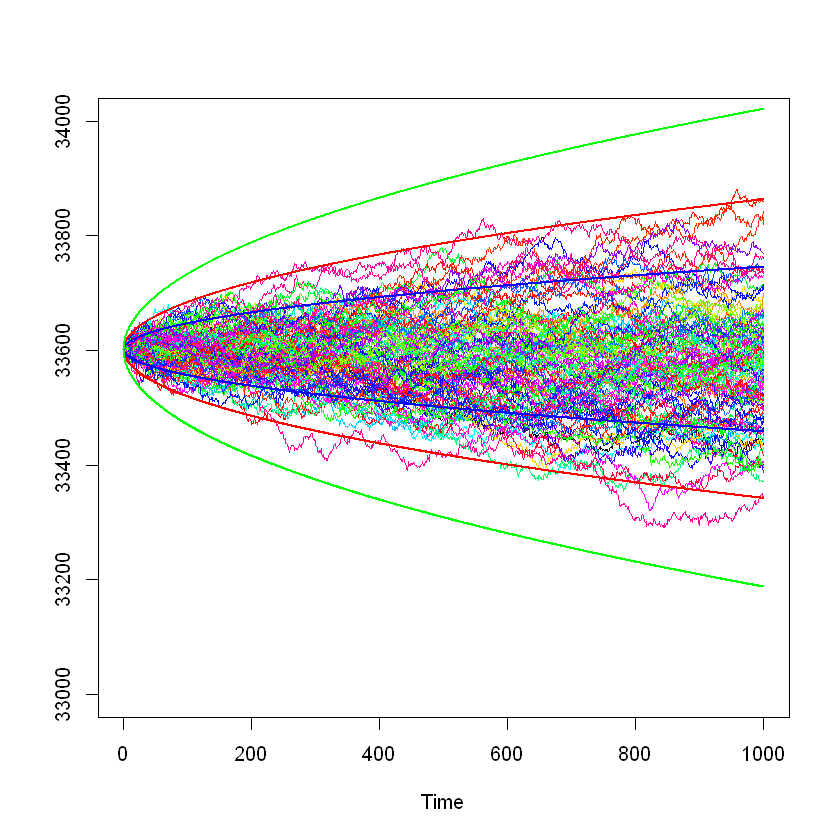

In [7]:
time_step  <- 1000
nsim       <- 100
t          <- seq(0,1,1/time_step)
delta_t <- t[2]-t[1]
# volatilita' normalizzata ad un anno (si assumono 250 giorni lavorativi)
sigma   <- s * sqrt(250) * sqrt(delta_t)
# drift 
drift   <- (m + .5*sigma*sigma)*delta_t
S0      <- Price[1]

# generiamo un path di 500 punti fra 0 e tmax
paths <- wiener(time_step, t )$y
S1    <- S0*exp(drift + sigma * paths)
plot( S1, type="l",ylim = c(33000,34000), xlab = "Time", ylab="" )

for(i in 1:nsim){
    paths <- wiener(time_step, t )$y
    S     <- S0*exp(drift + sigma * paths)
    lines( S , col=sample(rainbow(100)))
}

# 90-esimo percentile
p <- qnorm(0.9)
y1=S0*exp(drift+p*sigma*sqrt(t))
y2=S0*exp(drift-p*sigma*sqrt(t))
lines(y1, lwd=2,col='blue')
lines(y2, lwd=2,col='blue')

# 99-esimo percentile
p <- qnorm(0.99)
y1=S0*exp(drift+p*sigma*sqrt(t))
y2=S0*exp(drift-p*sigma*sqrt(t))
lines(y1, lwd=2,col='red')
lines(y2, lwd=2,col='red')

# 99.99-esimo percentile
p <- qnorm(0.9999)
y1=S0*exp(drift+p*sigma*sqrt(t))
y2=S0*exp(drift-p*sigma*sqrt(t))
lines(y1, lwd=2,col='green')
lines(y2, lwd=2,col='green')
